In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import analyze # takes some time since inits hax
from channel_dict import channel_dict
from tqdm import tqdm
import datetime
import pickle


%matplotlib inline

## Setup

In [2]:
ACTUALLY_OFF = [1, 2, 12, 26, 34, 62, 65, 79, 86, 88, 102, 118, 
                130, 134, 135, 139, 148, 150, 152, 162, 178, 183,
                190, 198, 206, 213, 214, 234, 239, 244]

In [3]:
import hax
#hax already initiated when analyze is imported

from spe_acceptance import data_dir_base


def data_exists(run_number):
    data_path=os.path.join(data_dir_base, 'run_%05d.h5' %run_number)
    return os.path.exists(data_path)

def all_data_exists(runlist):
    return all([data_exists(run) for run in runlist])

def file_to_list(runlist_file):
    return [int(run) for run in runlist_file.split('.')[0].split('_')[1:4]]

def get_run_time(run):
    return hax.runs.datasets[hax.runs.datasets.number == run].start.values[0]

In [4]:
#Load data from pickle file

bottom_runs = []
accs = []
upper_errs=[]
lower_errs=[]
errors = []

acc_dict={}

missing_runs = []
LED_off = []

with open('/project/lgrandi/xenon1t/spe_acceptance/ch_data/ch_data.pkl', 'rb') as cd:
    if os.stat('/project/lgrandi/xenon1t/spe_acceptance/ch_data/ch_data.pkl').st_size==0:
        data=[]
        print("No Data in the pickle file, load it in time_evolution_new")
    else:
        data=pickle.load(cd)
saved_runlists=[]

for cd in data:
    saved_runlists.append(cd.runlist)
    
    runlist = file_to_list(cd.runlist)
            
    bottom_run = runlist[0]
    topbulk_run = runlist[1]
    topring_run = runlist[2]
    
    acc=cd.acc
    acc_errs_l=cd.acc_errs_l
    acc_errs_u=cd.acc_errs_u
    acc_sys=cd.acc_sys
    acc_stat=cd.acc_stat
    occ=cd.occ
    occ_sys=cd.occ_sys
    occ_stat=cd.occ_stat
    
    acc_dict[cd.runlist] = acc
    
    accs.append(np.mean(acc))
    lower_errs.append(np.mean(acc_errs_l**2))
    upper_errs.append(np.mean(acc_errs_u**2))
    bottom_runs.append(bottom_run)
            
errors=np.array([lower_errs, upper_errs])
print(bottom_runs)

[9549, 12587, 7350, 6909, 6550, 7067, 12768, 11429, 7447, 16984, 10696, 6957, 12046, 17454, 7968, 7646, 18562, 11625, 17998, 18383, 10133, 8448, 7758, 6938, 16343, 9604, 9033, 7485, 11069, 7569, 16701, 8921, 15625, 14192, 13300, 15987, 6169, 6753, 7912, 12130, 5242, 5152, 8154, 13837, 18846, 17587, 12318, 8267, 10796, 6358, 5755, 9697, 13128, 5442, 10297, 9112, 11535, 17862, 9797, 11733, 12946, 8735, 7268, 16523, 10877, 8840, 7680, 6984, 11813, 15085, 18928, 10524, 8350, 5646, 6446, 8069, 15811, 10064, 18286, 17249, 14369, 17782, 7795, 6834, 14733, 10610, 9217, 5039, 15268, 13657, 12511, 11352, 8545, 14555, 18190, 9299, 15420, 8627, 12398, 14907, 5557, 12211, 10986, 5358, 17939, 7100, 6892]


In [5]:
#prints low acceptance bottom runs (<0.7)
bottom_runs = np.array(bottom_runs)
accs = np.array(accs)

print('low acceptance bottom runs: ',bottom_runs[np.where(accs < 0.7)])

low acceptance bottom runs:  []


In [6]:
def acceptance_curve_3runs(bottom_run, topbulk_run, topring_run):
    ret_acc, ret_errs = np.ones((248, 1099)), np.ones((248, 1099))
    run_list = [bottom_run, topbulk_run, topring_run]
    channel_lists = [channel_dict['bottom_channels'],
                     channel_dict['top_bulk'],
                     channel_dict['top_outer_ring']]
    for run, ch_list in zip(run_list, channel_lists):
        path = os.path.join(data_dir_base, 'run_%05d.h5' % run)
        if not os.path.exists(path):
            print("Acceptance data does not exist for run %d" % run)
        s = analyze.SPE(path)
        frac, errs = s.acceptance_by_channel
        ret_acc[ch_list] = frac[ch_list]
        ret_errs[ch_list] = errs[ch_list]
    return ret_acc, ret_errs

def find_file(run):
    return [f for f in os.listdir('runlists') if str(run) in f]

## Analysis on Outlier Runs

In [7]:
#Find outliers, plot acc of one of them
outlier_indices = np.where(accs < 0.85)
outliers = bottom_runs[outlier_indices]
run = outliers[1]
print('Run: ',run)
s = analyze.SPE('data/run_%05d.h5' % run)
x = s.data['bin_centers'].copy()
runlist = file_to_list(find_file(run)[0])

acc, err = acceptance_curve_3runs(runlist[0], runlist[1], runlist[2])
thresholds = analyze.get_thresholds(analyze.find_regular_run(int(run)))

acc_frac = acc[np.arange(248), 100 + np.array(thresholds[:248])]
print('Acceptance: ', np.median(acc_frac))
print(acc)
plt.figure(figsize=(9,6))
for ch, a in enumerate(acc):
    plt.plot(x, a, color='black', linewidth=1, alpha=0.6)
    
plt.xlim(-10, 200)
plt.xlabel('threshold')
plt.ylabel('spe acceptance')
#plt.savefig('acceptance_curve_%05d.png' % run)
plt.show()


IndexError: index 1 is out of bounds for axis 0 with size 0

In [8]:
#recalculates acc instead of relying on analyze
#Does this for all outlier runs
led = []
noise = []
for run in outliers:
    s = analyze.SPE('data/run_%05d.h5' % run)
    led.append(s.data['LED_amplitude'])
    noise.append(s.data['noise_amplitude'])


led = np.array(led)
noise = np.array(noise)
led = led.sum(axis=0)
print(led)
noise = noise.sum(axis=0)
corr = led[:108, :].sum(axis=0) / noise[:108, :].sum(axis=0)
noise *= corr
print(corr)
print(noise)

residual = (led - noise).T

acceptance = 1 - residual.cumsum(axis=1) / residual.sum(axis=1)[:, np.newaxis]
print(acceptance)
acceptance = np.clip(acceptance, -0.1, 1.1)

plt.figure(figsize=(9,6))
for ch, acc in enumerate(acceptance):
    plt.plot(x, acc, color='k')
plt.xlabel('Threshold')
plt.ylabel('SPE Acceptance')
plt.xlim(-10,200)
plt.show()

0.0


IndexError: invalid index to scalar variable.

In [ ]:
#finds thresholds, acc, occ and acc and occ errs for a single runlist
#Should be runlist of an outlier run

runlist='runlist_14192_14193_14195.txt'
runs = runlist.split('_')[1:4]
bot_run = int(runs[0])
tb_run = int(runs[1])
tr_run = int(runs[2][:-4])

thresholds = analyze.get_thresholds(analyze.find_regular_run(bot_run))
acc, err = analyze.acceptance_3runs(bot_run, tb_run, tr_run, thresholds)
occ, occ_err = analyze.occupancy_3runs(bot_run, tb_run, tr_run)

In [ ]:
#plot the occupancy of one runlist
plt.hist(occ, bins=50, range=(0,1.1))
plt.xlim(0,0.2)
plt.show()

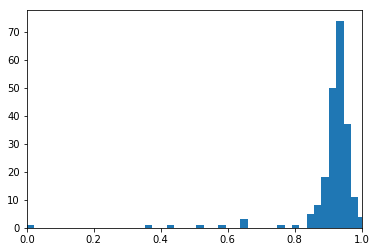

In [17]:
#plot the acceptance of one runlist
plt.hist(acc, bins=50, range=(0,1.1))
plt.xlim(0, 1)
plt.show()

In [ ]:
# get date of specific run

from make_runlist_new import get_dates
date_dict=get_dates(bottom_runs)

bad_run=14192
bad_date=date_dict[bad_run]
print('y/m/d')
print(bad_date)

In [23]:
#checks if channels that register as off are only the ones we know are actually off

my_off = np.where(occ < 0.05)[0]
print('in my_off but not actually_off:', [ch for ch in my_off if ch not in ACTUALLY_OFF])
print('opposite: ', [ch for ch in ACTUALLY_OFF if ch not in my_off])

in my_off but not actually_off: [137]
opposite:  []


## Individual Channels 

217
217


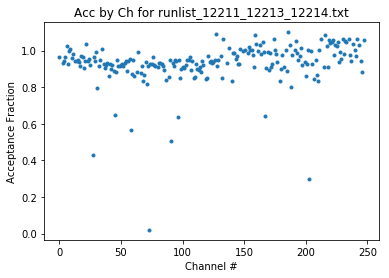

In [31]:
runlist= 'runlist_12211_12213_12214.txt' #manually enter runlist

bottom_run=file_to_list(runlist)[0]

#get acceptances
accs=acc_dict[runlist] 

ch=np.arange(248)
on_ch=np.delete(ch, my_off)
#plot acceptance of each channel
plt.figure()
plt.plot(on_ch, accs, marker='.', linestyle='none')
plt.ylabel('Acceptance Fraction')
plt.xlabel('Channel #')
plt.title('Acc by Ch for %s' %runlist)
plt.show()

In [38]:
ch_acc_dict={}

for ch, acc in zip(on_ch, accs):
    ch_acc_dict[acc]=ch

low_acc_ch=[]
for acc in accs:
    if acc<0.8:
        low_acc_ch.append(ch_acc_dict[acc])
        
print('Low acc ch: ', low_acc_ch)

Low acc ch:  [27, 31, 45, 58, 73, 91, 96, 167, 188, 203]


## Analysis of Systematic Errors

In [ ]:
#Sets up checks for arbitrary bin choice
from spe_acceptance import data_dir_base #/project/lgrandi/xenon1t/spe_acceptance/data
path = os.path.join(data_dir_base, 'run_%05d.h5' % tr_run)
s = analyze.SPE(path)
vals_to_check = [3,4,5,6,7,8,9]
occ_array = np.ones((248, len(vals_to_check)))
for i, val in enumerate(vals_to_check):
    occ_array[:,i] = -1*np.log(s.make_correction(val, 'amplitude'))
occ = np.mean(occ_array, axis=1)
myoff = np.where(occ < 0.1)[0]

In [ ]:
#plot LED and noise vs bins
plt.plot(s.data['bin_centers'], s.data['LED_amplitude'][:,0], color='black')
plt.plot(s.data['bin_centers'], s.data['noise_amplitude'][:,0], color='red')
plt.yscale('log')
plt.ylabel('Amplitude')
plt.xlabel('Bins')
plt.xlim(-50, 250)
plt.show()

In [ ]:
#plot a single acc curve vs just a channel on the same run

#checks if data for run exists
run_number = 14192
path = os.path.join(data_dir_base, 'run_%05d.h5' % run_number)
if not os.path.exists(path):
    print("Acceptance data does not exist for run %d" % run_number)
s = analyze.SPE(path)    

ch = 0

acc = s.acceptance(6, 'amplitude')
#x, acc2, acc2_errs = analyze.ch_curve(ch, run_number) #x is s.data['bin_centers']
#print(x, acc2, acc2_errs)
plt.plot(x, acc[ch])
#plt.errorbar(x, acc2, yerr=acc2_errs)
plt.xlim(-10, 150)
plt.show()

In [ ]:
def acceptance_fraction(run_number, thresholds):
    path = os.path.join(data_dir_base, 'run_%05d.h5' % run_number)
    if not os.path.exists(path):
        print("Acceptance data does not exist for run %d" % run_number)
    s = analyze.SPE(path)
    frac_array = np.ones((248, s.big_array.shape[-1]))
    ch_index = np.arange(248)
    thresholds = np.array(thresholds)
    bin0 = np.where(s.data['bin_centers'] == 0.5)[0][0]
    for i in range(s.big_array.shape[-1]):
        frac_array[:,i] = s.big_array[...,i][ch_index, thresholds[:248] + bin0]
    acc_frac = np.mean(frac_array, axis=1)
    acc_errs = np.std(frac_array, axis=1)
    return acc_frac, acc_errs

In [ ]:
thresholds = analyze.get_thresholds(analyze.find_regular_run(int(run)))
new_accs = analyze.acceptance_3runs(*tuple(runlist), thresholds=thresholds)[0]
print(accs)
thresh = np.array(thresholds)
len(thresh)

In [ ]:
run_number = 15628
path=os.path.join(data_dir_base, 'run_%05d.h5' % run_number)
s = analyze.SPE(path)

#acceptance fraction defined above, otherwise need to do analyze.acceptance_fraction
frac, errs = acceptance_fraction(run_number, thresh)

In [ ]:
arr = np.ones(5)
arr[[2,4]] = [2,2]
print(arr)
arr=s.big_array

In [ ]:
from channel_dict import channel_dict

bot_run = 15625
tb_run = 15627
tr_run = 15628

bottom = channel_dict['bottom_channels']
topbulk = channel_dict['top_bulk']
topring = channel_dict['top_outer_ring']

real_acc, real_errs = np.ones(248), np.ones(248)

for run, channels in zip([bot_run, tb_run, tr_run], [bottom, topbulk, topring]):
    frac, errs = acceptance_fraction(run_number, thresh)
    real_acc[channels] = frac[channels]
    real_errs[channels] = errs[channels]

In [ ]:
#Plots the acceptance vs threshold for each bin choice
example_run = sorted(bottom_runs)[-1]
runlist = file_to_list(find_file(example_run)[0])
ch = 0
s = analyze.SPE('data/run_%05d.h5' % runlist[2])
x = s.data['bin_centers']
corr_values = [4,5,6,7,8,9,10]

plt.figure(figsize=(9,6))
for i in range(s.big_array.shape[-1]):
    accs = s.big_array[ch,:,i]
    plt.plot(x, accs, label='corr value %d' % corr_values[i])
plt.xlim(-10, 150)
plt.legend(loc=(1.01, 0.6))
plt.grid()
plt.xlabel('threshold')
plt.ylabel('spe acceptance')
plt.savefig('example_systematic.png')
plt.show()
    


In [ ]:
#Systematics

ch = 193
run = 11069
s = analyze.SPE('data/run_%05d.h5' % run)

x = s.data['bin_centers']

#Bins vs LED/Noise Amplitude for individual channel

plt.figure(figsize=(9,6))
plt.plot(x, s.data['LED_amplitude'][:,ch], color ='black')
plt.plot(x, s.data['noise_amplitude'][:,ch], color='red' )
plt.xlabel('Bins')
plt.ylabel('Amplitude')
plt.xlim(-20, 50)
plt.yscale('log')
plt.show()

#Bins vs Residual Value for individual channel
val = 4
plt.figure(figsize=(9,6))
plt.plot(x, s.residual(val)[ch], color ='black')
plt.plot(x, s.data['noise_amplitude'][:,ch], color='red' )
plt.xlim(-20, 50)
plt.xlabel('Bins')
plt.ylabel('Residual')
plt.yscale('log')
plt.show()

#Bins vs acceptance for individual channel
plt.figure(figsize=(9,6))
plt.plot(x, s.acceptance(val)[ch], color ='black')
#plt.plot(x, s.data['noise_amplitude'][:,ch], color='red' )
plt.xlabel('Bins')
#plt.yscale('log')
plt.ylabel('Acceptance')
plt.xlim(-20, 50)
plt.show()